## Accessing Met Office COVID-19 response data on Azure

This dataset contains weather data that has been curated for researchers looking to understand links between COVID-19 and environmental factors.

This dataset is stored in the East US 2 Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [ai4edata-metofficecovid19](https://aka.ms/ai4edata-metofficecovid19).

### Environment setup

In [1]:
import matplotlib.pyplot as plt 
import datetime

from azure.storage.blob import BlobClient, ContainerClient
from collections import namedtuple

plt.rcParams['figure.figsize'] = (20.0, 10.0)

### Set up the blob client with the connection details

In [3]:
account_url = 'https://metdatasa.blob.core.windows.net/'
container_name = 'covid19-response'

# Create the ContainerClient object which will be used to enumerate blobs
container_client = ContainerClient(account_url=account_url,
                                   container_name=container_name,
                                   credential=None)

### List the files under metoffice_global_daily/t1o5m_max

In [4]:
max_blobs = 10
for i_blob,blob in enumerate(container_client.list_blobs(
    name_starts_with='metoffice_global_daily/t1o5m_max')):
    print(f'{blob.name}')
    if i_blob >= max_blobs:
        break

metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200101.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200102.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200103.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200104.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200105.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200106.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200107.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200108.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200109.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200110.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200111.nc


### Choose a file based on date and time

In [6]:
data_end = (datetime.datetime.now() - datetime.timedelta(days=9)).date()
data_start = datetime.date(2020,1,1)

def url_from_properties(model, param, freq, stat=None, day=None, hour=None):
    
    assert model in ["global","ukv"]
    assert param in ["rain", "sh", "snow", "t1o5m", "pmsl","precip","sw"]
    assert freq in ["daily","hourly"]
    if freq == 'daily':
        assert stat in ['max', 'min', 'mean']
    else:
        assert stat is None  
    assert data_start <= day <= data_end
    
    stat = '_'+stat if stat else ''

    filepath = f'metoffice_{model}_{freq}/{param}{stat}/{model}_{freq}_{param}{stat}_{day:%Y%m%d}.nc'
    return f"{account_url}/{container_name}/{filepath}"

Properties = namedtuple('Properties',["model","param","freq","stat","day"])

files = [
    Properties("global","precip","daily","mean",datetime.date(2020,3,3)),
    Properties("ukv","t1o5m","daily","min",datetime.date(2020,4,1)),
    Properties("ukv","snow","hourly",None,datetime.date(2020,2,2)),
]

for file in files:
    path = url_from_properties(*file)
    print(path.replace(account_url,''))

/covid19-response/metoffice_global_daily/precip_mean/global_daily_precip_mean_20200303.nc
/covid19-response/metoffice_ukv_daily/t1o5m_min/ukv_daily_t1o5m_min_20200401.nc
/covid19-response/metoffice_ukv_hourly/snow/ukv_hourly_snow_20200202.nc


### Stream blob into memory and load dataset in xarray

In [7]:
import xarray as xr
from io import BytesIO

data_description = Properties("global","precip","daily","mean",datetime.date(2020,1,30))
file_data = BytesIO(BlobClient.from_blob_url(
    url_from_properties(*data_description)).download_blob().readall())
ds = xr.open_dataset(file_data)
ds

<xarray.Dataset>
Dimensions:                       (bnds: 2, latitude: 1920, longitude: 2560)
Coordinates:
  * latitude                      (latitude) float32 -89.95 -89.86 ... 89.95
  * longitude                     (longitude) float32 0.07031 0.2109 ... 359.9
    forecast_period               timedelta64[ns] ...
    forecast_reference_time       datetime64[ns] ...
    time                          datetime64[ns] ...
Dimensions without coordinates: bnds
Data variables:
    precipitation_flux            (latitude, longitude) float32 ...
    latitude_longitude            int32 ...
    forecast_period_bnds          (bnds) float64 ...
    forecast_reference_time_bnds  (bnds) datetime64[ns] ...
    time_bnds                     (bnds) datetime64[ns] ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   11.2
    Conventions:  CF-1.5

### Plot this data granule

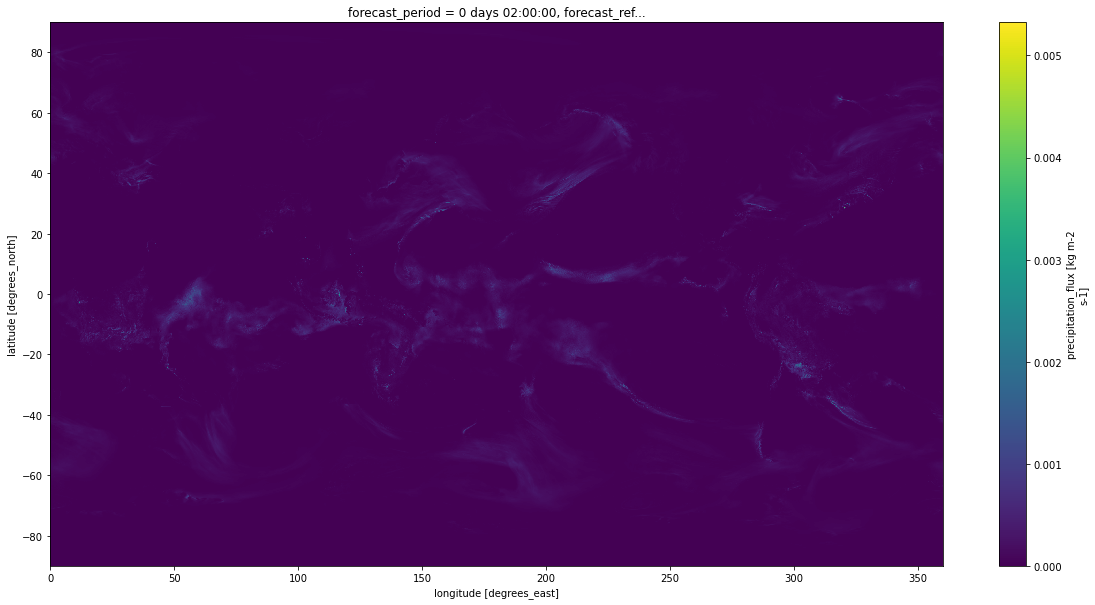

In [8]:
ds.precipitation_flux.plot();